In [1]:
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Loading

In [0]:
(train_data, validation_data), info = tfds.load(
    'plant_village',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]']
)

In [3]:
num_training_examples = info.splits['train[:80%]'].num_examples
num_validation_examples = info.splits['train[80%:]'].num_examples
num_classes = info.features['label'].num_classes
class_names = np.array(info.features['label'].names)

print("Number of training examples: ", num_training_examples)
print("Number of classes: ", num_classes)
print(class_names)

Number of training examples:  43442
Number of classes:  38
['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy' 'Cherry___healthy'
 'Cherry___Powdery_mildew' 'Corn___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn___Common_rust' 'Corn___healthy' 'Corn___Northern_Leaf_Blight'
 'Grape___Black_rot' 'Grape___Esca_(Black_Measles)' 'Grape___healthy'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___healthy'
 'Potato___Late_blight' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___healthy'
 'Strawberry___Leaf_scorch' 'Tomato___Bacterial_spot'
 'Tomato___Early_blight' 'Tomato___healthy' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tom

In [4]:
# check if the images have the same size
for i, image in enumerate(train_data.take(5)):
    print(f"Image{i+1} size: {image[0].shape}, Label: {image[1]}")

Image1 size: (256, 256, 3), Label: 35
Image2 size: (256, 256, 3), Label: 15
Image3 size: (256, 256, 3), Label: 31
Image4 size: (256, 256, 3), Label: 20
Image5 size: (256, 256, 3), Label: 3


## Preprocessing Data

In [0]:
def normalize(image, label):
    image = tf.cast(image, 'float32')
    image /= 255.0
    return image, label

BATCH_SIZE = 32

train_data = train_data.shuffle(num_training_examples//4).repeat().map(normalize).batch(BATCH_SIZE)
val_data = validation_data.map(normalize).batch(BATCH_SIZE)

## Build Model

In [0]:
model = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
            layers.MaxPooling2D(),

            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(240, activation='relu'),
            layers.Dense(38)
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=25,
                    steps_per_epoch=math.ceil(num_training_examples/BATCH_SIZE),
                    validation_data=val_data,
                    validation_steps=math.ceil(num_validation_examples/BATCH_SIZE),
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 1/25
1358/1358 [==============================] - 189s 139ms/step - loss: 0.8905 - accuracy: 0.7410 - val_loss: 0.4240 - val_accuracy: 0.8644
Epoch 2/25
1358/1358 [==============================] - 185s 136ms/step - loss: 0.3071 - accuracy: 0.9006 - val_loss: 0.2625 - val_accuracy: 0.9175
Epoch 3/25
1358/1358 [==============================] - 184s 135ms/step - loss: 0.2012 - accuracy: 0.9344 - val_loss: 0.1966 - val_accuracy: 0.9380
Epoch 4/25
1358/1358 [==============================] - 184s 135ms/step - loss: 0.1476 - accuracy: 0.9511 - val_loss: 0.2145 - val_accuracy: 0.9367
Epoch 5/25
1358/1358 [==============================] - 181s 133ms/step - loss: 0.1124 - accuracy: 0.9627 - val_loss: 0.1789 - val_accuracy: 0.9456
Epoch 6/25
1358/1358 [==============================] - 181s 133ms/step - loss: 0.1040 - accuracy: 0.9659 - val_loss: 0.2676 - val_accuracy: 0.9239
Epoch 7/25
1358/1358 [==============================] - 180s 133ms/step - loss: 0.0918 - accuracy: 0.9707 - val_

Text(0.5, 1.0, 'Training and Validation Loss')

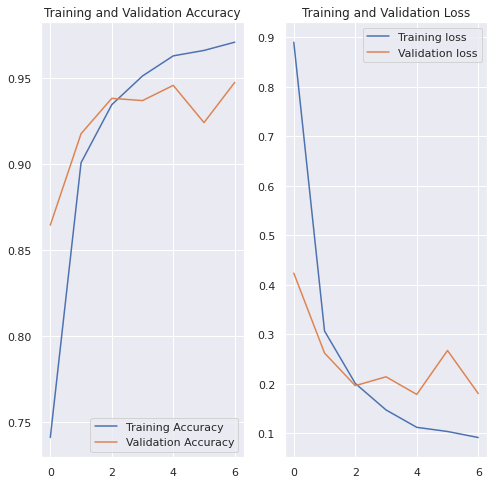

In [8]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Check Predictions


In [9]:
image_batch, label_batch = next(iter(val_data.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['Tomato___healthy',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Late_blight',
       'Strawberry___healthy', 'Pepper,_bell___Bacterial_spot',
       'Tomato___healthy', 'Orange___Haunglongbing_(Citrus_greening)',
       'Potato___Early_blight',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Apple___Black_rot', 'Squash___Powdery_mildew',
       'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Black_rot',
       'Tomato___Target_Spot', 'Blueberry___healthy', 'Soybean___healthy',
       'Raspberry___healthy', 'Tomato___Late_blight',
       'Tomato___Leaf_Mold', 'Tomato___Target_Spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Blueberry___healthy',
       'Squash___Powdery_mildew', 'Tomato___Bacterial_spot',
       'Tomato___Bacterial_spot', 'Grape___healthy', 'Corn___Common_rust',
       'Blueberry___healthy', 'Soybean___healt

In [10]:
print("True labels:         ", label_batch)
print("Predicted labels:    ", predicted_ids)

True labels:          [30 34 32 15 31 26 18 30 15 20 34  1 25 15  1 35  4 24 23 31 32 13 37  4
 25 28 28 13  8  4 24  8]
Predicted labels:     [30 34 34 15 31 26 18 30 15 20 34  1 25 15  1 35  4 24 23 31 32 35 37  4
 25 28 28 13  8  4 24  8]


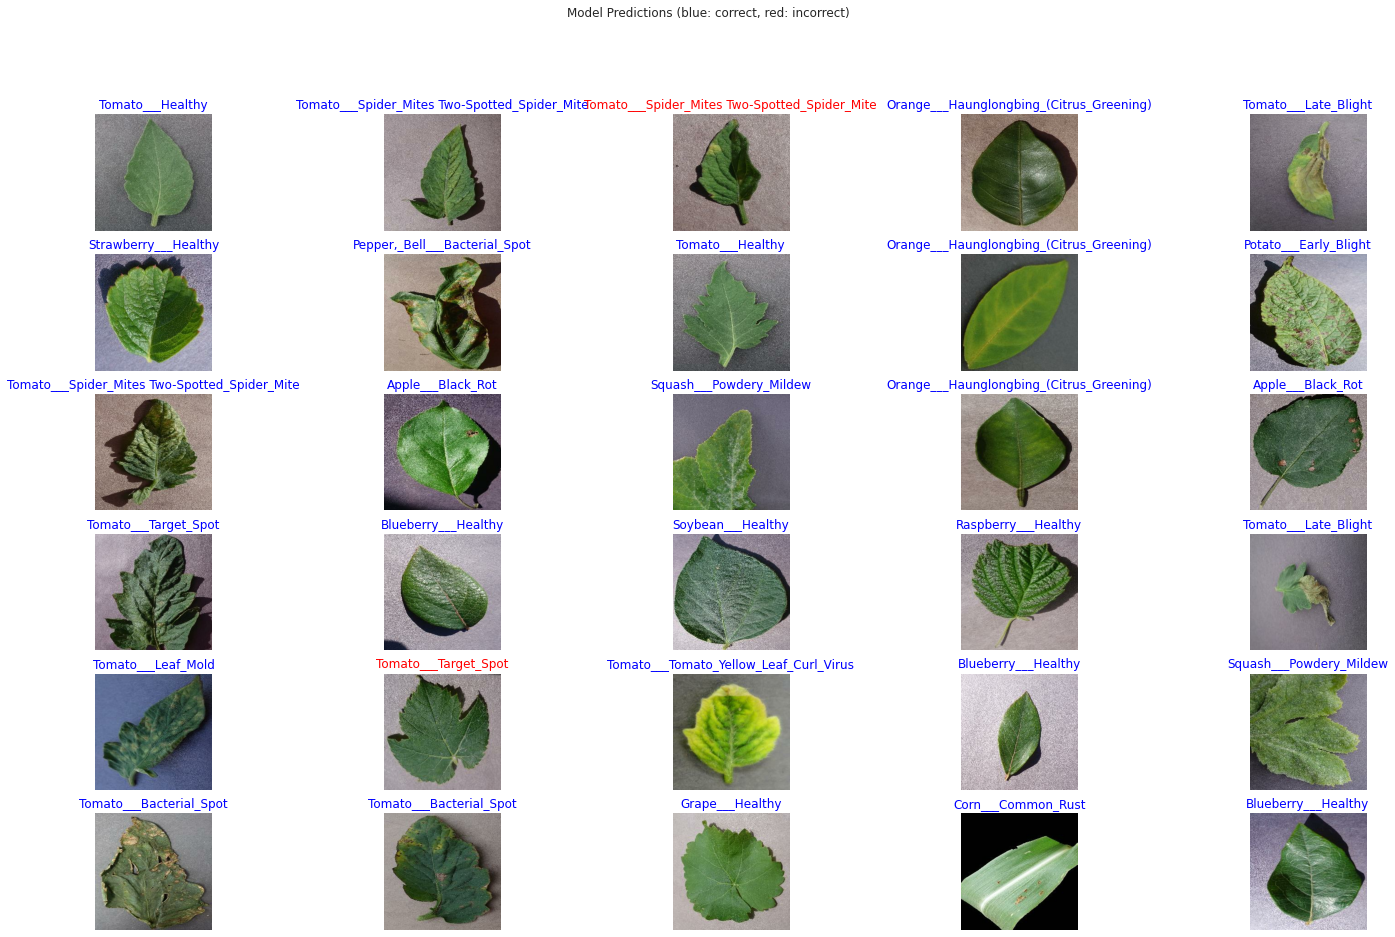

In [15]:
plt.figure(figsize=(25, 15))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i])
    color = 'blue' if predicted_ids[i] == label_batch[i] else 'red'
    plt.title(predicted_class_names[i].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model Predictions (blue: correct, red: incorrect)")

## Save the Model

In [12]:
t = time.time()
export_path = f"PDD{int(t)}"
print(export_path)

tf.saved_model.save(model, export_path)

PDD1588773523
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: PDD1588773523/assets


INFO:tensorflow:Assets written to: PDD1588773523/assets


In [13]:
!zip -r model.zip {export_path}

  adding: PDD1588773523/ (stored 0%)
  adding: PDD1588773523/variables/ (stored 0%)
  adding: PDD1588773523/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: PDD1588773523/variables/variables.index (deflated 68%)
  adding: PDD1588773523/variables/variables.data-00001-of-00002 (deflated 25%)
  adding: PDD1588773523/saved_model.pb (deflated 89%)
  adding: PDD1588773523/assets/ (stored 0%)


In [14]:
!ls

model.zip  PDD1588773523  sample_data


In [0]:
try: 
    from google.colab import files
    files.download('./model.zip')
except ImportError:
    pass